# Analysis of Mutual Fund Size on Performance for Small Cap Value Funds

Contributing Members: 
- Jordan Pflum (jdp3998)
- Shan Ali (sca763)
- David Cruz(dc33332)
- Alishah Vidhani (av36285)

Date: 10/10/2020


### Connect to WRDS

In [1]:
import wrds
db = wrds.Connection()

Enter your WRDS username [jorda]: jordandpflum
Enter your password: ····················


WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


# Testing

### Classification Table

In [4]:
sql_query = """
-- Summary Table
SELECT
    crsp_q_mutualfunds.fund_style.CRSP_FUNDNO,
    crsp_q_mutualfunds.fund_style.BEGDT,
    crsp_q_mutualfunds.fund_style.ENDDT,
    crsp_q_mutualfunds.fund_style.LIPPER_CLASS
FROM 
    crsp_q_mutualfunds.fund_style
WHERE
    crsp_q_mutualfunds.fund_style.LIPPER_CLASS = 'SCVE'
LIMIT 10
"""
data_query = db.raw_sql(sql_query)
data_query.head()

,crsp_fundno,begdt,enddt,lipper_class
0,292.0,1999-12-31,2000-08-31,SCVE
1,479.0,1999-12-31,2000-12-30,SCVE
2,657.0,1999-12-31,2000-02-29,SCVE
3,671.0,1999-12-31,2000-06-30,SCVE
4,709.0,1999-12-31,2000-01-31,SCVE


### Monthly Return Data

In [5]:
sql_query = """
-- Return Table
SELECT
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO,
    crsp_q_mutualfunds.monthly_returns.CALDT,
    crsp_q_mutualfunds.monthly_returns.MRET
FROM 
    crsp_q_mutualfunds.monthly_returns
LIMIT 10
"""
data_query = db.raw_sql(sql_query)
data_query.head()

,crsp_fundno,caldt,mret
0,1.0,1997-02-28,NaN
1,1.0,1997-03-31,-0.011789
2,1.0,1997-04-30,0.008417
3,1.0,1997-05-30,0.013523
4,1.0,1997-06-30,0.012502


### Monthly TNA Table

In [6]:
sql_query = """
-- TNA Table
SELECT
    crsp_q_mutualfunds.monthly_tna.CRSP_FUNDNO,
    crsp_q_mutualfunds.monthly_tna.CALDT,
    crsp_q_mutualfunds.monthly_tna.MTNA
FROM 
    crsp_q_mutualfunds.monthly_tna
LIMIT 10
"""
data_query = db.raw_sql(sql_query)
data_query.head()

,crsp_fundno,caldt,mtna
0,1.0,1997-01-31,0.100
1,1.0,1997-02-28,3.926
2,1.0,1997-03-31,12.081
3,1.0,1997-04-30,20.540
4,1.0,1997-05-30,26.157


## Monthly Return vs Monthly TNA

### SQL Query

In [21]:
sql_query = """
SELECT
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO,
    crsp_q_mutualfunds.monthly_returns.CALDT,
    crsp_q_mutualfunds.monthly_returns.MRET,
    crsp_q_mutualfunds.monthly_tna.MTNA
FROM 
    crsp_q_mutualfunds.monthly_returns
INNER JOIN
    crsp_q_mutualfunds.monthly_tna
ON
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO = crsp_q_mutualfunds.monthly_tna.CRSP_FUNDNO
INNER JOIN
    crsp_q_mutualfunds.fund_style
ON
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO = crsp_q_mutualfunds.fund_style.CRSP_FUNDNO
WHERE
    crsp_q_mutualfunds.fund_style.BEGDT <= crsp_q_mutualfunds.monthly_returns.CALDT AND
    crsp_q_mutualfunds.fund_style.ENDDT >= crsp_q_mutualfunds.monthly_returns.CALDT AND
    crsp_q_mutualfunds.monthly_returns.CALDT = crsp_q_mutualfunds.monthly_tna.CALDT AND
    crsp_q_mutualfunds.fund_style.LIPPER_CLASS = 'SCVE'
ORDER BY
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO,
    crsp_q_mutualfunds.monthly_returns.CALDT
"""

data_query = db.raw_sql(sql_query)

### Regression

In [22]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Drop NAs
data_queryClean = data_query.dropna(axis=0)
reg = LinearRegression().fit(np.array(data_queryClean['mtna'].values).reshape(-1,1), 
                             np.array(data_queryClean['mret'].values).reshape(-1,1)
                            )
print('Coefficient: ', reg.coef_[0][0])
print('Intercept: ', reg.intercept_[0])

Coefficient:  3.7360515651713603e-07
Intercept:  0.00729084206665463


In [23]:
import statsmodels.api as sm
import pandas as pd

X_with_intercept = np.empty(shape=(len(data_queryClean['mtna']), 2), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:2] = pd.DataFrame(data_queryClean['mtna']).values

sm.OLS(np.array(data_queryClean['mret'].values).reshape(-1,1),
       np.array(X_with_intercept)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.612
Date:                Tue, 12 Jan 2021   Prob (F-statistic):              0.106
Time:                        18:27:07   Log-Likelihood:             1.1278e+05
No. Observations:               79606   AIC:                        -2.256e+05
Df Residuals:                   79604   BIC:                        -2.255e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0073      0.000     33.699      0.000       0.007       0.008
x1          3.736e-07   2.31e-07      1.616      0.106   -7.95e-08    8.27e-07
==============================================================================
Omnibus:                    19927.989   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1541403.954
Skew:                          -0.025   Prob(JB):                         0.00
Kurtosis:                      24.557   Cond. No.                         974.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plotting

<function matplotlib.pyplot.show(close=None, block=None)>

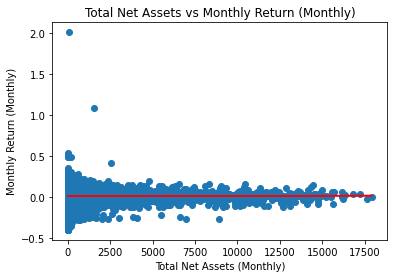

In [27]:
import matplotlib.pyplot as plt

plt.scatter(data_queryClean['mtna'], data_queryClean['mret'])
plt.plot(data_queryClean['mtna'],reg.predict(np.array(data_queryClean['mtna'].values).reshape(-1,1)), color='red')
plt.xlabel('Total Net Assets (Monthly)')
plt.ylabel('Monthly Return (Monthly)')
plt.title('Total Net Assets vs Monthly Return (Monthly)')
#plt.savefig('Images/returnVsTNA_Monthly.png')
plt.show

## Monthly Risk vs Average Total Net Assets

In [7]:
# get std
mstd = data_query.groupby(['crsp_fundno']).agg({'mret':'std','mtna':'mean'})
# Drop NAs
mstd = mstd.dropna(axis=0)

### Regression

In [9]:

reg = LinearRegression().fit(np.array(mstd['mtna'].values).reshape(-1,1), 
                             np.array(mstd['mret'].values).reshape(-1,1)
                            )
print('Coefficient: ', reg.coef_[0][0])
print('Intercept: ', reg.intercept_[0])
print('R-squared: ', reg.score(np.array(mstd['mtna'].values).reshape(-1,1), 
                             np.array(mstd['mret'].values).reshape(-1,1)))

Coefficient:  -1.666713396613785e-06
Intercept:  0.059234756646400696
R-squared:  0.001883022418393332


In [10]:
import statsmodels.api as sm
import pandas as pd

X_with_intercept = np.empty(shape=(len(mstd['mtna']), 2), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:2] = pd.DataFrame(mstd['mtna']).values

sm.OLS(np.array(mstd['mret'].values).reshape(-1,1),
       np.array(X_with_intercept)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.602
Date:                Tue, 12 Jan 2021   Prob (F-statistic):              0.107
Time:                        18:06:18   Log-Likelihood:                 3404.6
No. Observations:                1381   AIC:                            -6805.
Df Residuals:                    1379   BIC:                            -6795.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0592      0.001    103.283      0.000       0.058       0.060
x1         -1.667e-06   1.03e-06     -1.613      0.107   -3.69e-06     3.6e-07
==============================================================================
Omnibus:                      612.208   Durbin-Watson:                   1.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4603.261
Skew:                           1.897   Prob(JB):                         0.00
Kurtosis:                      11.100   Cond. No.                         575.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plotting

<function matplotlib.pyplot.show(close=None, block=None)>

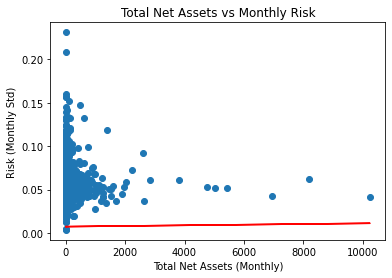

In [29]:
# plot
plt.scatter(mstd['mtna'], mstd['mret'])
plt.plot(mstd['mtna'],reg.predict(np.array(mstd['mtna'].values).reshape(-1,1)), color='red')
plt.xlabel('Total Net Assets (Monthly)')
plt.ylabel('Risk (Monthly Std)')
plt.title('Total Net Assets vs Monthly Risk')
#plt.savefig('Images/riskVsTNA_Monthly.png')
plt.show

## Annualzed Returns vs Average TNA

### SQL Query

In [31]:
sql_query = """
SELECT
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO,
    AVG(crsp_q_mutualfunds.monthly_returns.MRET) AS AVG_MRET,
    AVG(crsp_q_mutualfunds.monthly_tna.MTNA) AS AVG_MNTA
FROM 
    crsp_q_mutualfunds.monthly_returns
INNER JOIN
    crsp_q_mutualfunds.monthly_tna
ON
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO = crsp_q_mutualfunds.monthly_tna.CRSP_FUNDNO
INNER JOIN
    crsp_q_mutualfunds.fund_style
ON
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO = crsp_q_mutualfunds.fund_style.CRSP_FUNDNO
WHERE
    crsp_q_mutualfunds.fund_style.BEGDT <= crsp_q_mutualfunds.monthly_returns.CALDT AND
    crsp_q_mutualfunds.fund_style.ENDDT >= crsp_q_mutualfunds.monthly_returns.CALDT AND
    crsp_q_mutualfunds.monthly_returns.CALDT = crsp_q_mutualfunds.monthly_tna.CALDT AND
    crsp_q_mutualfunds.fund_style.LIPPER_CLASS = 'SCVE'
GROUP BY
    crsp_q_mutualfunds.monthly_returns.CRSP_FUNDNO
    
"""

data_query = db.raw_sql(sql_query)

# Annualize Returns
data_query['annualReturn'] = (1+data_query['avg_mret'])**12 - 1

### Regression

In [32]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Drop NAs
data_queryClean = data_query.dropna(axis=0)
reg = LinearRegression().fit(np.array(data_queryClean['avg_mnta'].values).reshape(-1,1), 
                             np.array(data_queryClean['annualReturn'].values).reshape(-1,1)
                            )
print('Coefficient: ', reg.coef_[0][0])
print('Intercept: ', reg.intercept_[0])

Coefficient:  -3.7054026879250534e-06
Intercept:  0.12559512095682215


In [33]:
import statsmodels.api as sm
import pandas as pd

X_with_intercept = np.empty(shape=(len(data_queryClean['avg_mnta']), 2), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:2] = pd.DataFrame(data_queryClean['avg_mnta']).values

sm.OLS(np.array(data_queryClean['annualReturn'].values).reshape(-1,1),
       np.array(X_with_intercept)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02915
Date:                Tue, 12 Jan 2021   Prob (F-statistic):              0.864
Time:                        18:28:38   Log-Likelihood:                -808.65
No. Observations:                1395   AIC:                             1621.
Df Residuals:                    1393   BIC:                             1632.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1256      0.012     10.479      0.000       0.102       0.149
x1         -3.705e-06   2.17e-05     -0.171      0.864   -4.63e-05    3.89e-05
==============================================================================
Omnibus:                     2773.568   Durbin-Watson:                   0.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4839316.170
Skew:                          15.426   Prob(JB):                         0.00
Kurtosis:                     289.889   Cond. No.                         572.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plotting

<function matplotlib.pyplot.show(close=None, block=None)>

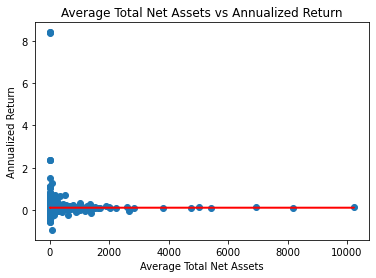

In [35]:
import matplotlib.pyplot as plt

plt.scatter(data_queryClean['avg_mnta'], data_queryClean['annualReturn'])
plt.plot(data_queryClean['avg_mnta'],reg.predict(np.array(data_queryClean['annualReturn'].values).reshape(-1,1)), color='red')
plt.xlabel('Average Total Net Assets')
plt.ylabel('Annualized Return')
plt.title('Average Total Net Assets vs Annualized Return')
#plt.savefig('Images/returnVsTNA_annualized.png')
plt.show

## Annual Risk vs Average TNA

In [16]:
# annualize std
astd = mstd.copy()
astd['astd'] = astd['mret']*np.sqrt(12)

# Drop NAs
astd = astd.dropna(axis=0)

### Regression

In [17]:
reg = LinearRegression().fit(np.array(astd['mtna'].values).reshape(-1,1), 
                             np.array(astd['astd'].values).reshape(-1,1)
                            )
print('Coefficient: ', reg.coef_[0][0])
print('Intercept: ', reg.intercept_[0])
print('R-squared: ', reg.score(np.array(astd['mtna'].values).reshape(-1,1), 
                             np.array(astd['astd'].values).reshape(-1,1)))

Coefficient:  -5.773664569181545e-06
Intercept:  0.2051952161710885
R-squared:  0.001883022418393443


In [18]:
import statsmodels.api as sm
import pandas as pd

X_with_intercept = np.empty(shape=(len(astd['mtna']), 2), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:2] = pd.DataFrame(astd['mtna']).values

sm.OLS(np.array(astd['astd'].values).reshape(-1,1),
       np.array(X_with_intercept)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.602
Date:                Tue, 12 Jan 2021   Prob (F-statistic):              0.107
Time:                        18:07:21   Log-Likelihood:                 1688.8
No. Observations:                1381   AIC:                            -3374.
Df Residuals:                    1379   BIC:                            -3363.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2052      0.002    103.283      0.000       0.201       0.209
x1         -5.774e-06   3.58e-06     -1.613      0.107   -1.28e-05    1.25e-06
==============================================================================
Omnibus:                      612.208   Durbin-Watson:                   1.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4603.261
Skew:                           1.897   Prob(JB):                         0.00
Kurtosis:                      11.100   Cond. No.                         575.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plotting

<function matplotlib.pyplot.show(close=None, block=None)>

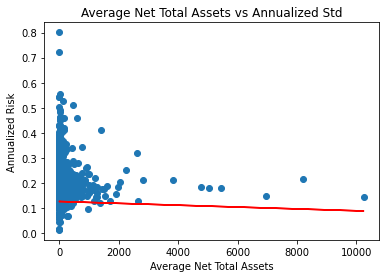

In [37]:
# plot
plt.scatter(astd['mtna'], astd['astd'])
plt.plot(astd['mtna'],reg.predict(np.array(astd['mtna'].values).reshape(-1,1)), color='red')
plt.xlabel('Average Net Total Assets')
plt.ylabel('Annualized Risk')
plt.title('Average Net Total Assets vs Annualized Std')
#plt.savefig('Images/riskVsTNA_annualized.png')
plt.show